# Sales Performance Analysis : Insurance Context

This notebook analyzes commercial performance in an insurance sales context.
The objective is to assess sales effectiveness, target achievement, and key
drivers of performance across advisors, products, regions, and time.

The analysis is designed to support operational and management decision-making.


## Data overview & model assumptions

The analysis relies on five core datasets:
- advisors: sales force structure and regional assignment
- products: insurance product catalog
- leads: commercial opportunities generated by advisors
- transactions: converted leads resulting in signed policies
- objectives : sale's goals to achieve by advisors

Key assumptions:
- Each transaction originates from a single lead
- Each lead is associated with one insurance product
- Regional analysis is derived from advisor assignment


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.style.use('default')

In [5]:
DATA_PATH = "../data/raw"

advisors = pd.read_csv(f"{DATA_PATH}/advisors.csv")
products = pd.read_csv(f"{DATA_PATH}/products.csv")
leads = pd.read_csv(f"{DATA_PATH}/leads.csv")
transactions = pd.read_csv(f"{DATA_PATH}/transactions.csv")
objectives = pd.read_csv(f"{DATA_PATH}/objectives.csv")

In [6]:
for name, df in {
    "Advisors": advisors,
    "Leads": leads,
    "Transactions": transactions,
    "Products": products,
    "Objectives": objectives
}.items():
    print(f"{name} Dataset:")
    print(df.shape, end="\n\n")

Advisors Dataset:
(40, 6)

Leads Dataset:
(3200, 6)

Transactions Dataset:
(287, 6)

Products Dataset:
(4, 4)

Objectives Dataset:
(480, 3)



## Data quality & sanity checks

In [7]:
assert leads["product_id"].isna().sum() == 0
assert transactions["lead_id"].isna().sum() == 0
assert transactions["advisor_id"].isna().sum() == 0

Basic data quality checks confirm consistency between leads, transactions, and products.

In [42]:
# Unicity checks
assert advisors["advisor_id"].is_unique
assert products["product_id"].is_unique
assert leads["lead_id"].is_unique

## Funnel commercial 

Où se perd la performance ?

### Vue globale

In [11]:
total_leads = len(leads)
converted_leads = leads["lead_id"].isin(transactions["lead_id"]).sum()

pd.DataFrame({
    "Stage": ["Leads", "Converted Leads"],
    "Count": [total_leads, converted_leads]
})

,Stage,Count
0,Leads,3200
1,Converted Leads,287


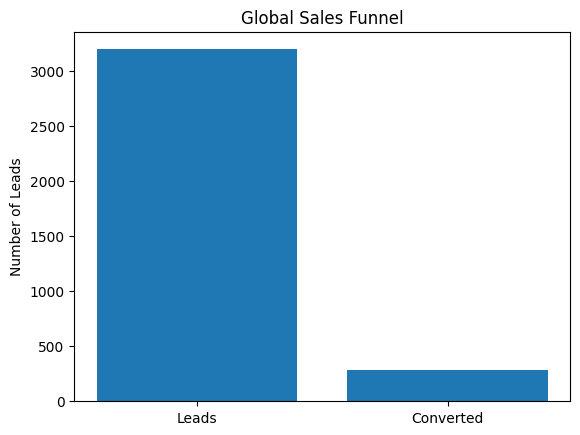

In [13]:
plt.bar(["Leads", "Converted"], [total_leads, converted_leads])
plt.title("Global Sales Funnel")
plt.ylabel("Number of Leads");

The leads conversion rate is almost 9%.

### Funnel par source de lead

In [14]:
funnel_source = (
    leads.assign(converted=leads["lead_id"].isin(transactions["lead_id"]))
    .groupby("lead_source")
    .agg(
        leads=("lead_id", "count"),
        conversions=("converted", "sum")
    )
)

funnel_source["conversion_rate"] = funnel_source["conversions"] / funnel_source["leads"]
funnel_source.sort_values("conversion_rate", ascending=False)

,leads,conversions,conversion_rate
lead_source,,,
campaign,778,84,0.107969
enterprise,793,69,0.087011
terrain,825,70,0.084848
recommendation,804,64,0.079602


A significant drop between leads and conversions indicates that sales performance
is primarily driven by conversion efficiency rather than lead generation volume.


## Performances commerciales

### Primes collectées

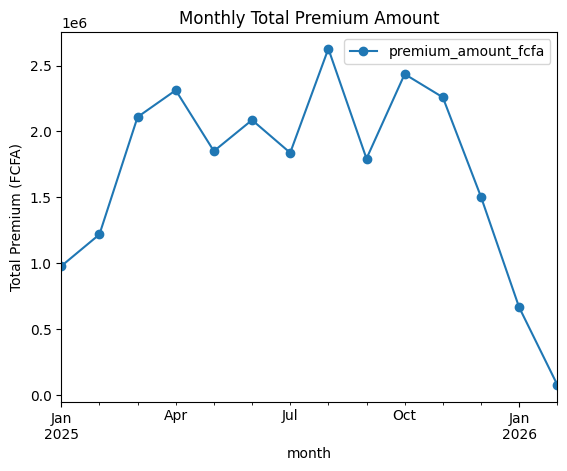

In [17]:
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])

transactions["month"] = transactions["transaction_date"].dt.to_period("M")

monthly_premium = (
    transactions.groupby("month")["premium_amount_fcfa"]
    .sum()
    .reset_index()
)
monthly_premium.plot(x="month", y="premium_amount_fcfa", kind="line", marker="o")
plt.title("Monthly Total Premium Amount")
plt.ylabel("Total Premium (FCFA)");

The most money entry has been on August and October.

### Performance par conseiller

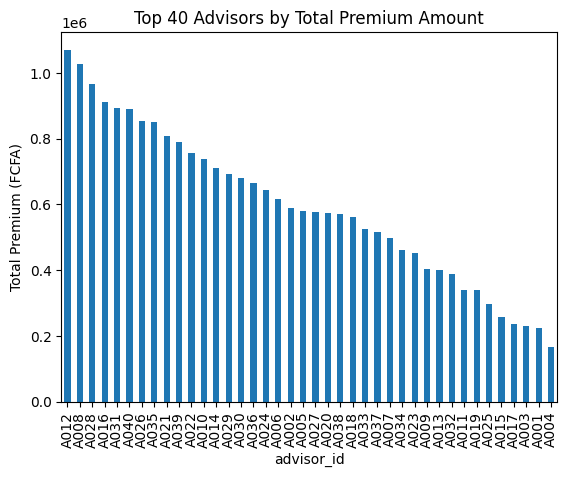

In [22]:
advisor_perf = (
    transactions.groupby("advisor_id")
    .agg(
        contracts=("policy_number", "count"),
        total_premium=("premium_amount_fcfa", "sum")
    )
    .sort_values("total_premium", ascending=False)
)
advisor_perf.head(40).plot(
    y="total_premium",
    kind="bar",
    legend=False
)
plt.title("Top 40 Advisors by Total Premium Amount")
plt.ylabel("Total Premium (FCFA)");

Sales performance is highly concentrated among a limited number of advisors,
suggesting uneven productivity across the sales force.


## Analyse de la performance produit

In [24]:
transactions = transactions.merge(
    leads[["lead_id", "product_id"]],
    on="lead_id",
    how="left"
)

In [26]:
product_perf = (
    transactions
    .merge(products, on="product_id")
    .groupby("product_name")
    .agg(
        contracts=("policy_number", "count"),
        total_premium=("premium_amount_fcfa", "sum"),
        avg_premium=("premium_amount_fcfa", "mean")
    )
)
product_perf.sort_values("total_premium", ascending=False)

,contracts,total_premium,avg_premium
product_name,,,
Retraite Plus,78,6642265,85157.243590
Épargne Éducation,77,6512000,84571.428571
Temporaire Décès,66,5362274,81246.575758
Mixte Avantage,66,5224345,79156.742424


Retraite Plus & Epargne éducation are the products that bring the most money.

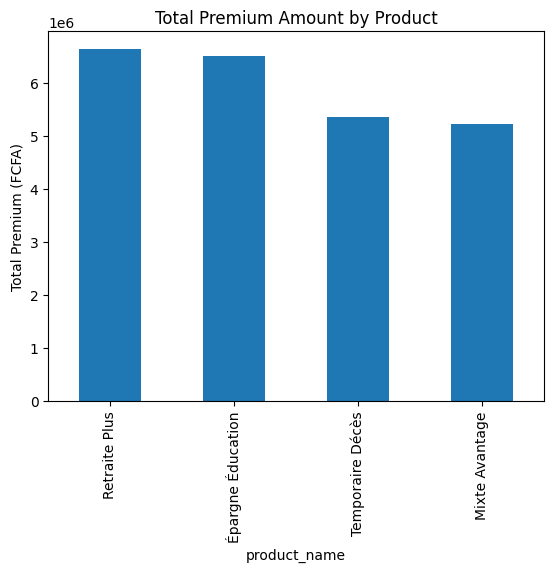

In [27]:
product_perf.sort_values("total_premium", ascending=False).plot(
    y="total_premium",
    kind="bar",
    legend=False
)
plt.title("Total Premium Amount by Product")
plt.ylabel("Total Premium (FCFA)");

## Analyse régionale

In [28]:
leads_region = leads.merge(
    advisors[["advisor_id", "region"]],
    on="advisor_id"
)

region_perf = (
    leads_region.assign(converted=leads_region["lead_id"].isin(transactions["lead_id"]))
    .groupby("region")
    .agg(
        leads=("lead_id", "count"),
        conversions=("converted", "sum")
    )
)

region_perf["conversion_rate"] = (
    region_perf["conversions"] / region_perf["leads"]
)
region_perf.sort_values("conversion_rate", ascending=False)

,leads,conversions,conversion_rate
region,,,
Abomey-Calavi,989,108,0.109201
Bohicon,646,61,0.094427
Parakou,380,32,0.084211
Cotonou,384,29,0.075521
Porto-Novo,318,24,0.075472
Djougou,483,33,0.068323


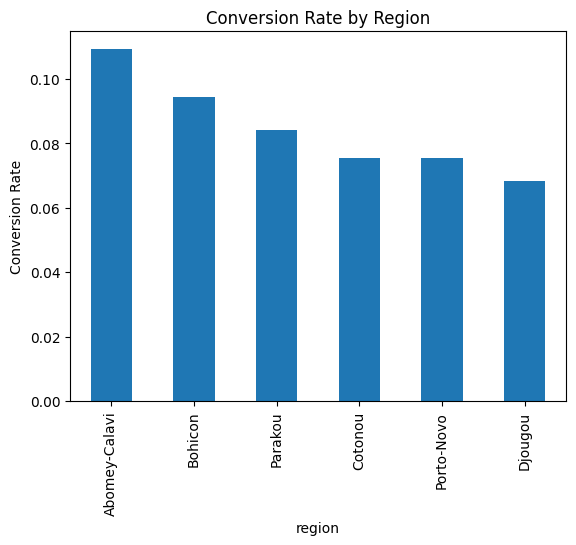

In [29]:
region_perf.sort_values("conversion_rate", ascending=False).plot(
    y="conversion_rate",
    kind="bar",
    legend=False
)
plt.title("Conversion Rate by Region")
plt.ylabel("Conversion Rate");

Conversion rates vary significantly across regions, suggesting local market or
execution differences that require targeted management actions.


## Objectifs vs Réalisé

In [31]:
# Ramenons les ventes au niveau mensuel
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
transactions["month"] = transactions["transaction_date"].dt.to_period("M")

In [32]:
objectives["month"] = pd.PeriodIndex(objectives["month"], freq="M")

In [36]:
monthly_perf = (
    transactions
    .groupby(["advisor_id", "month"])
    .agg(realized=("premium_amount_fcfa", "sum"))
    .reset_index()
)

perf_vs_target = objectives.merge(
    monthly_perf,
    on=["advisor_id", "month"],
    how="left"
).fillna(0)

perf_vs_target["achievement_rate"] = (
    perf_vs_target["realized"] / perf_vs_target["target_premium_fcfa"]
)
perf_vs_target.groupby("month")[["realized","target_premium_fcfa"]].sum()

,realized,target_premium_fcfa
month,,
2025-01,976129.0,182993886
2025-02,1216861.0,184164926
2025-03,2108652.0,181414595
2025-04,2312244.0,181049819
2025-05,1849781.0,186705615
2025-06,2085960.0,173978865
2025-07,1836898.0,180339563
2025-08,2627595.0,181567193
2025-09,1792588.0,190360903


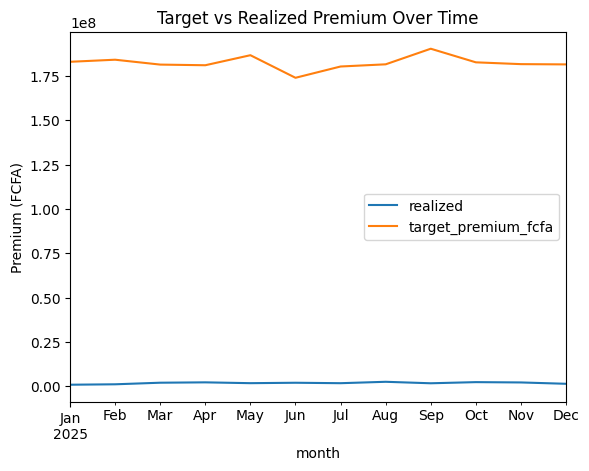

In [37]:
perf_vs_target.groupby("month")[["realized","target_premium_fcfa"]].sum().plot()
plt.title("Target vs Realized Premium Over Time")
plt.ylabel("Premium (FCFA)");

This is bad, really bad. We need to investigate more to find out what has been going on and why.

## Analyse temporelle avancée

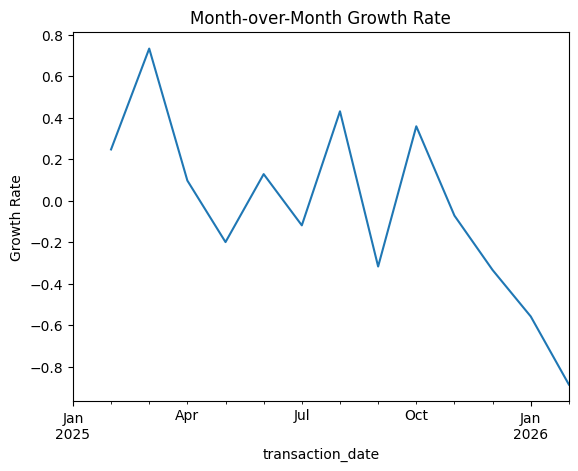

In [38]:
monthly_trend = (
    transactions
    .groupby(transactions["transaction_date"].dt.to_period("M"))
    ["premium_amount_fcfa"].sum()
)

monthly_trend.pct_change().plot()
plt.title("Month-over-Month Growth Rate")
plt.ylabel("Growth Rate");

The volatility of monthly growth rates suggests sensitivity to individual advisor
performance and seasonal sales patterns.


## Executive Summary

- Sales performance is primarily driven by conversion efficiency.
- Advisor productivity is uneven, with strong concentration of results.
- Product mix plays a critical role in premium generation.
- Regional disparities suggest opportunities for targeted interventions.

This analysis provides a solid foundation for operational steering and
management-level decision-making.
